# Classification trees

In this notebook, we will train and tune a classification tree on the adult income dataset. We will be using the `DecisionTreeClassifier` class from the `sklearn.tree` module. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.rcParams.update(**{
    'figure.dpi':150
})

In [2]:
adult = pd.read_csv('../data/adult_train.csv')

# response - convert to 0/1 variable
y = 1*(adult['income']==' >50K').values

# drop two  of the columns
# education and education-num convey the same information
adult = adult.drop(['education','fnlwgt'],axis=1)

features = adult.drop('income',axis=1) 

The dataset has both numerical and categorical columns. 
1. The numerical predictors don't need to be standardized for trees. 
2. Trees can natively handle categorical predictors. However, `DecisionTreeClassifier` in scikit-learn requires the categorical predictors to be explicitly **one-hot encoded**. This is unlike `rpart` in R. Calculating feature importance for categorical predictors will be slightly different. 

There are multiple methods to create one-hot encoded representations of categorical variables. In the neural network classification notebook, we use the `OneHotEncoder` from the `sklearn.preprocessing` module. Here, we use the `pd.get_dummies` function. An attractive feature with this function is that it generates column names which can be later supplied to the tree model during plots or when querying feature importances.

In [3]:
# extract different types of columns
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']
cat_cols = [col for col in features.columns if col not in numerical_cols]

# onehot encode categorical predictors using `get_dummies` function
df_cat_dummies = pd.get_dummies(features[cat_cols])


df_cat_dummies

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# concatenate columns
X = pd.concat([features[numerical_cols],df_cat_dummies],axis=1)

print('Number of features: %d'%X.shape[1])

Number of features: 91


In [5]:
# tree model
clf_tree = DecisionTreeClassifier(
    criterion='gini', # criterion for splits
                      # 'gini' - Gini index (default)
                      # 'entropy' - deviance
    min_samples_leaf=50, # equivalent of minbucket in rpart
    ccp_alpha=0 # cost-complexity parameter
)

# grow a tree with restrictions only on minimum
# number of observations in the leaf nodes
_ = clf_tree.fit(X,y)

## Weakest link pruning

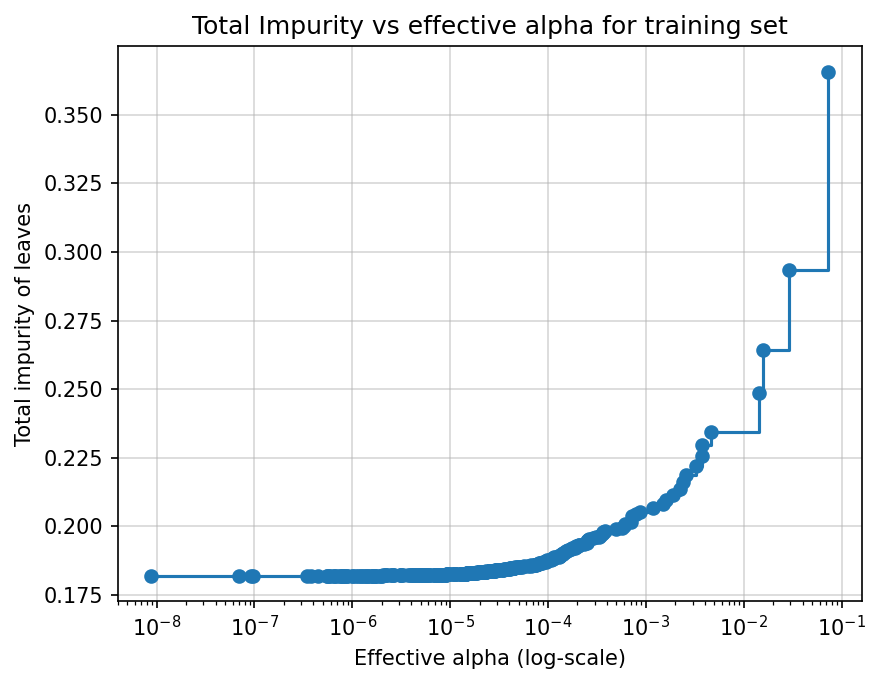

In [6]:
# compute the cost-complexity pruning path for the tree
ccp_path = clf_tree.cost_complexity_pruning_path(X,y)


ccp_alphas, impurities = ccp_path.ccp_alphas[1:], ccp_path.impurities[1:]

# plot of impurities vs ccp_alpha
fig, ax = plt.subplots()
_ = ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
_ = ax.set_xlabel("Effective alpha (log-scale)")
_ = ax.set_ylabel("Total impurity of leaves")
_ = ax.set_title("Total Impurity vs effective alpha for training set")
_ = ax.semilogx()
_ = ax.grid(alpha=0.5)

In [7]:
# only look at alpha value > 1e-6
ccp_alphas = ccp_alphas[ccp_alphas>1e-6]

np.random.seed(1234)
kf = KFold(n_splits=5,shuffle=True) # equivalent to using xval=5 in rpart.control
acc_tree = np.empty((kf.n_splits,ccp_alphas.shape[0]))

for i,(train_index,test_index) in enumerate(kf.split(X)):
    
    # initialize tree for this fold and fit large tree
    tree_fold = DecisionTreeClassifier(min_samples_leaf=50).fit(X.iloc[train_index,:],y[train_index])
    
    for j,alpha in enumerate(ccp_alphas):
        # update the value of alpha
        tree_fold.set_params(**{'ccp_alpha':alpha})
        
        # prune the tree further
        _ = tree_fold._prune_tree()
        
        # compute predictions and evaluate accuracy on test set 
        y_pred_test = tree_fold.predict(X.iloc[test_index,:])
        acc_tree[i,j] = accuracy_score(y[test_index],y_pred_test)
        
        
# CV estimates
acc_cv = acc_tree.mean(axis=0)
acc_se_cv = acc_tree.std(axis=0)/np.sqrt(acc_tree.shape[0])

In [8]:
# rule 1 - max accuracy
idx_max = acc_cv.argmax()


print('Best 5-fold CV accuracy..........: %5.3f'%acc_cv[idx_max])
print('Alpha with best CV accuracy......: %5.3e'%ccp_alphas[idx_max])

Best 5-fold CV accuracy..........: 0.860
Alpha with best CV accuracy......: 5.419e-05


## Final model

In [9]:
# prune back initial tree with the best CV accuracy
clf_tree.set_params(ccp_alpha=ccp_alphas[idx_max])
clf_tree._prune_tree()


# class-probabilities - .predict_proba
p_hat = clf_tree.predict_proba(X)
# class predictions - threshold 0.5
y_hat = 1*(p_hat[:,1]>=0.5)

# training metrics
train_acc = accuracy_score(y,y_hat)
print('Training accuracy: %5.3f'% train_acc)

Training accuracy: 0.866


## Visualization

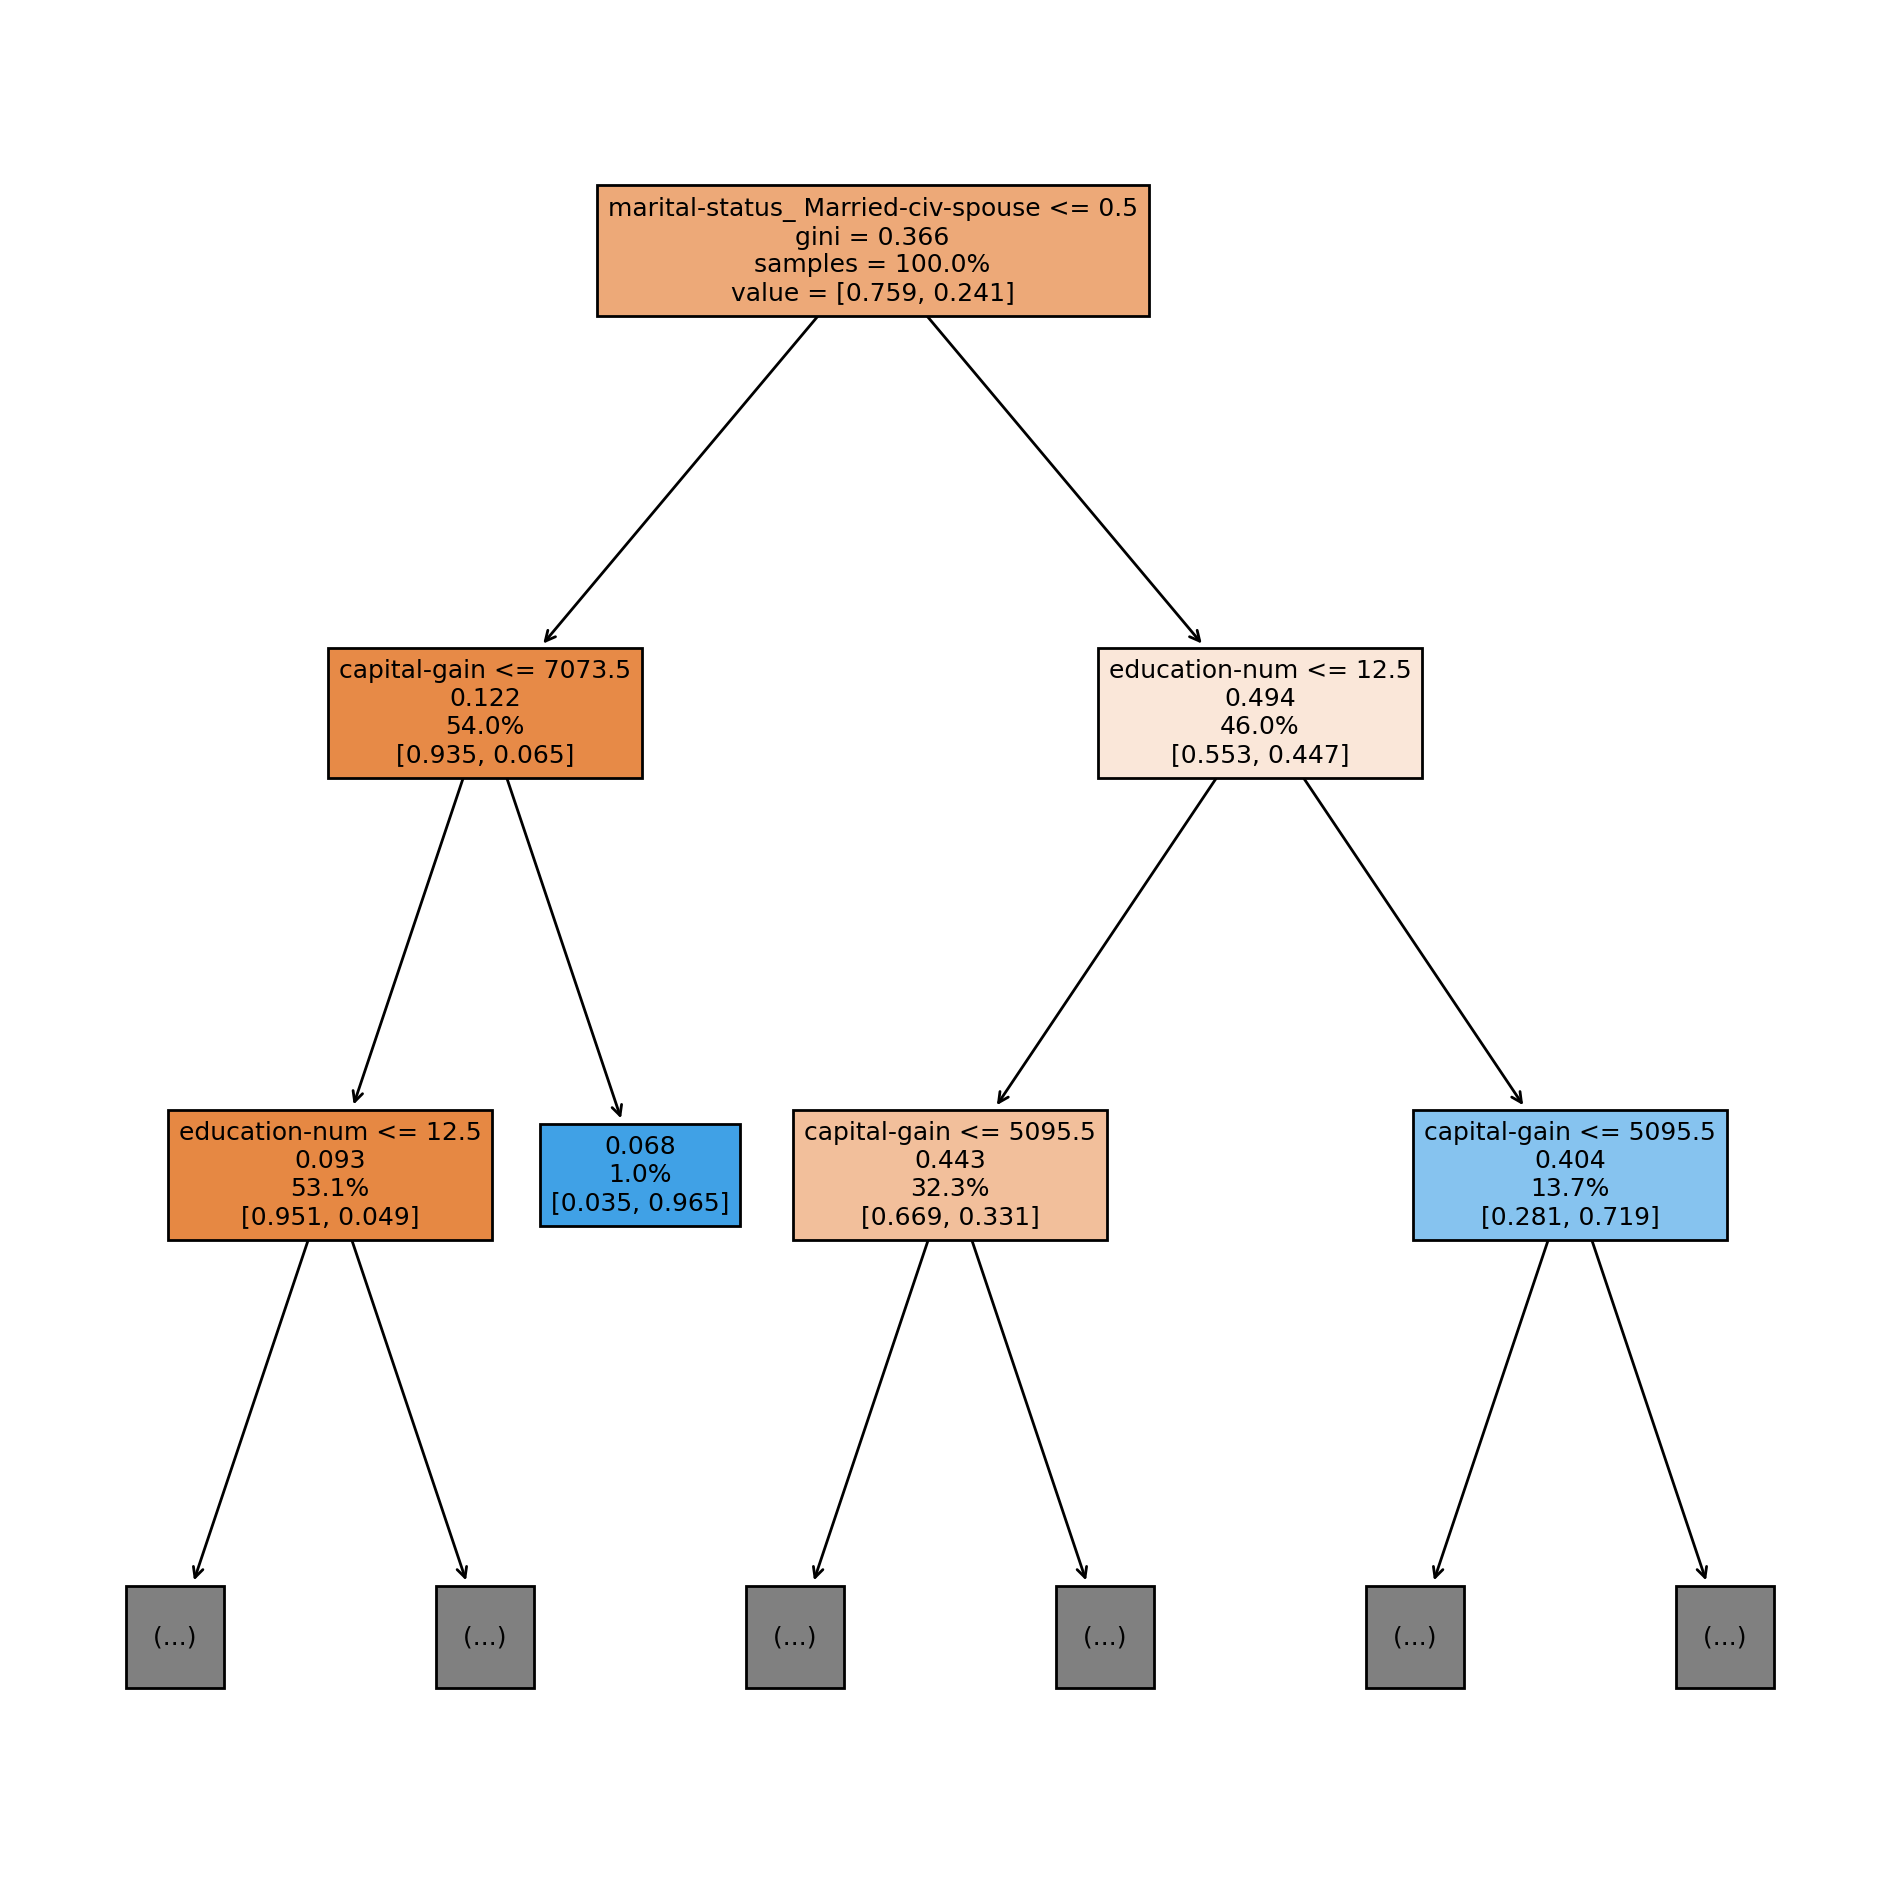

In [10]:
from sklearn.tree import plot_tree
# visualize tree
fig = plt.figure(figsize=(12,12),dpi=200)
_ = plot_tree(
    clf_tree,
    feature_names=X.columns,
    max_depth=2,
    label='root',
    fontsize=9,
    proportion=True,
    filled=True 
)

## Feature importances

In [11]:
# (normalized) total reduction in gini index
feat_imp = pd.Series(clf_tree.feature_importances_,index=X.columns).sort_values(ascending=False)


feat_imp.round(4).head(20)

marital-status_ Married-civ-spouse    0.4012
education-num                         0.2194
capital-gain                          0.1917
capital-loss                          0.0518
age                                   0.0478
hours-per-week                        0.0380
occupation_ Exec-managerial           0.0116
workclass_ Self-emp-not-inc           0.0081
occupation_ Prof-specialty            0.0075
relationship_ Wife                    0.0051
occupation_ Other-service             0.0027
sex_ Male                             0.0023
occupation_ Farming-fishing           0.0021
workclass_ Federal-gov                0.0019
occupation_ Sales                     0.0018
occupation_ Tech-support              0.0018
workclass_ Private                    0.0012
occupation_ Transport-moving          0.0012
marital-status_ Never-married         0.0010
occupation_ Machine-op-inspct         0.0009
dtype: float64

The importance metric for a categorical predictor is the sum of the feature importances of all its one-hot encoded features. 

In [12]:
# total importance of predictor marital status
marital_idxs = feat_imp.index.str.contains('marital-status')
feat_imp[marital_idxs].sum()

0.4021731833661967

In [13]:
# total importance of occupation
occupation_idxs = feat_imp.index.str.contains('occupation')
feat_imp[occupation_idxs].sum()

0.03003937919702864